# CoCoRaHS Verification for Feb 2019 California Precipitation


![](https://ggweather.com/water/sf.png)
**Figure**: San Francisco 2018-2019 season rain from Golden Gate Weather (2019-04-23).

## Create a new WinDB2
```
mike@honami:~/vscode-workspace/cocorahs-verification$ create-windb2.py localhost postgres cocorahs-california-1
```

## Mask for California only
CoCoRaHS is mostly only in the United States. So a Shapefile of the US boundaries was acquired from [here](https://www.weather.gov/gis/USStates) and used as a mask for the forecast data.

Insert the US state Shapefile into the WinDB2:
```
mike@honami:~/vscode-workspace/cocorahs-verification/data-to-import/national-weather-service$ shp2pgsql -s 4269 s_11au16.shp us_boundary_r1 | psql -U postgres cocorahs-california-1 
```
... and delete everything except California in the WinDB2:
```
cocorahs-california-1=# CREATE TABLE california_boundary_r1 AS SELECT * FROM us_boundary_r1 WHERE state='CA';

 ```

## Create a new GFS 0.25 deg domain
Created a new domain (using an arbitrary `gfs.0p25.*` file) with the `california_boundary_r1` shape as a domain mask:
```
(.venv) mike@honami:/data/gfs-forecasts/2019/hours-0-thru-72-sample$ insert-gfs-file.py localhost postgres cocorahs-california-1 -n gfs.0p25.2019012818.f078.grib2 -m california_boundary_r1
```
Verified that the points looked sane by creating a map in QGIS of the WinDB2 points and the mask (note there's an [issue](https://github.com/wxmiked/windb2/issues/28) that caused some of the points to go missing.

Also created a backup/dump of the WinDB2 at this point to speed up development:
```
(.venv) mike@honami:/data/gfs-forecasts/2019/hours-0-thru-72-sample$ pg_dump -U postgres cocorahs-california-1 > cocorahs-california-1-pgdump-empty-db-2019-04-24.sql
```
This dump can be recovered like:
```
(.venv) mike@honami:/data/gfs-forecasts/2019/hours-0-thru-72-sample$ cat cocorahs-california-1-pgdump-empty-db-2019-04-24.sql | psql -U postgres eraseme
```

## Sample data for 0 thru 72 hour forecasts
Inserted only 0-72 hour data for development purposes:
```
(.venv) mike@honami:/data/gfs-forecasts/2019/hours-0-thru-72-sample$ for i in `ls gfs.*`; do time LOGLEVEL=DEBUG insert-gfs-file.py localhost postgres cocorahs-california-1 -d 1 $i; done
```

## Converting to mm/hr precip
The GFS variable for total precipitation rate is in $kg/m^2$ and the CoCoRaHS observations are in inches. Use the Pint library and the assumption that 

We need the density of water, which varies with temperature to make this calculation. From [weatherspark.com](https://weatherspark.com/m/557/2/Average-Weather-in-February-in-San-Francisco-California-United-States#Sections-Temperature), assumed the average February temperature in California was $50^o F (12.2^o C)$ based on the average San Francisco temperature. Therefore the density of water at that temperature is $.999475 g/cm^3$ according to [csgnetwork.com](http://www.csgnetwork.com/waterinformation.html).
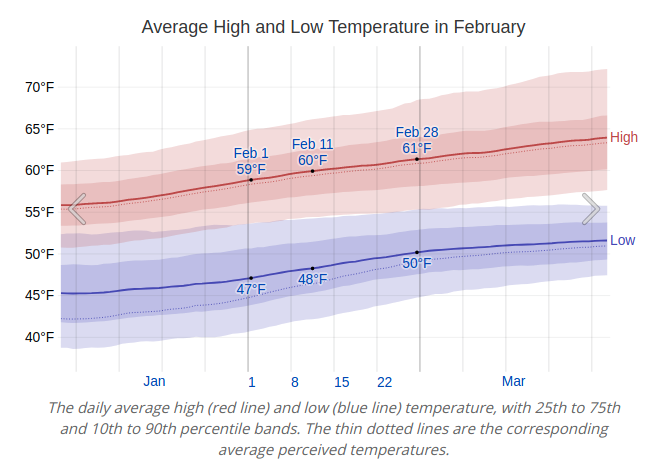

In [42]:
# Calculate the conversion between the PRATE units and inches per second for later use
import pint
ureg = pint.UnitRegistry()
prate_units = (ureg.kilogram / ureg.meter**2 / ureg.second)
h2o_density = 0.999457 * ureg.gram / ureg.centimeter**3
h2o_density.ito_base_units()
print(h2o_density)
conv_prate_to_inch_per_sec = (prate_units / h2o_density).to(ureg.inch / ureg.sec)
conv_prate_to_inch_per_sec

999.4569999999999 kilogram / meter ** 3


<Quantity(0.03939146830744843, 'inch / second')>